# Interactive Notebook - From Accuracy to Versatility: Analysing Text Classification Models regarding Transfer Learning

Daniil Gannota, Luis Sanchez and Niklas Stoehr

## Notebook overview

To execute this notebook and fiddle around with it, copy it to your own Google Drive:

**File -> Save a copy in Drive **

This notebook allows you to freely experiment with and reproduce the findings from the paper “From Accuracy to Versatility: Analysing Text Classification Models regarding Transfer Learning”. There are four main parts:

1. Load the environment
2. Select the configurations of the transfer
3. Pre-train the model on source and later retrain the model on target domain
4. Present the results

## Motivation

A strong condition in many machine learning scenarios is that the training and the test data are of the same feature space, the same distribution and independent and identically distributed. Transfer Learning relaxes this conditions by suggesting to shift a model trained on a source domain to a related target domain. The models in this notebook can be pre-trained on selected classes of DBPedia and then "transferred" to a target domain of other classes. The code measures the semantic similarity between classes using word2vec embeddings. The measurements are meant to encouraged you to individually select different classes in the source and the target domain and experiment with the transfer learning performance.

You have the option to directly compare the Transformer Model with an attention-based bi-directional LSTM and a naive Logistic Regression baseline in similar domain settings. The notebook lets you easily freeze different layers, adjust learning rates and other hyperparameters, pursing the goal to improve the models’ eligibility for transfer learning.

While we coded the Logistic Regression baseline from scratch using PyTorch, the initial code for the latter two models was inspired by the following GitHub repositories:

– Transformer Model implemented in TensorFlow (https://github.com/Kyubyong/transformer) <br/>
– Transformer Model implemented in TensorFlow (https://github.com/TobiasLee/Text-Classification)

<br/>
<br/>

<img src="https://raw.githubusercontent.com/danikgan/nlp-data/master/figures/methodology.png" width="600" />

<br/>
<br/>

**NOTE:** We are using 0.01 fraction of source dataset to train every model, except for Attention-Based Bi-LSTM which uses 0.001 to speed up learning time.

# 1. Loading Environment and create main variables

In [0]:
#@title Import libraries

from google.colab import files
from google.colab import drive

import pandas as pd
import io
from gensim.models import Word2Vec
import pickle

import requests
import os
import time

from gensim.models import Word2Vec
from tqdm import tqdm_notebook as tqdm
import urllib.request

import progressbar
import requests

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import numpy as np
import random

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.rnn import BasicLSTMCell

from torch.utils import data
import os
import torch.utils.data as data_utils

import torch
import random
from torch import nn
from torchtext import data as torchtext_data

import matplotlib.pylab as plt
import numpy as np
import scipy.optimize
from matplotlib import gridspec

import seaborn as sns
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
#@title Load DBPedia Dataset and Semantic Class Vectors

# Load in from Github Download

url_data_train = 'https://media.githubusercontent.com/media/danikgan/nlp-data/master/train.csv'
train_df = pd.read_csv(url_data_train, error_bad_lines=False, header=None)
train_df.columns =  ["class", "title", "content"]

url_data_val = 'https://media.githubusercontent.com/media/danikgan/nlp-data/master/test.csv'
test_df = pd.read_csv(url_data_val, error_bad_lines=False, header=None)
test_df.columns =  ["class", "title", "content"]

class_num_mapping = {1: "Company", 2: "Education", 3: "Artist", 4: "Athlete", 5: "OfficeHolder", 6: "Transportation", 7: "Building", 8: "Nature", 9: "Village", 10: "Animal", 11: "Plant", 12: "Album", 13: "Film", 14: "Writing"}

url_data_train = 'https://raw.githubusercontent.com/danikgan/nlp-data/master/semantic_vectors.csv'
semantic_vectors_df = pd.read_csv(url_data_train, error_bad_lines=False, header=None)

semantic_class_vectors = {}
for i in range(len(semantic_vectors_df)):
  row = semantic_vectors_df.values[i][:]
  semantic_class_vectors[row[0]] = {'<mean>':np.array(row[1:])} 

In [0]:
#@title Set up auxiliary functions and variables


#______________________________________________________________________
### Dataset Creator

class dataset_creator:
  
  
  def __init__(self, task_settings, train_df, test_df, class_num_mapping, semantic_class_vectors):
    
      self.train_df = train_df
      self.test_df = test_df
      self.class_num_mapping = class_num_mapping
      self.task_settings = task_settings
      self.semantic_class_vectors = semantic_class_vectors
            
      self.create_transfer_dataset(task_settings)
      self.compute_semantic_statistics(task_settings, class_num_mapping)
      
        
        
  def create_transfer_dataset(self, task_settings):
  
      self.source_train_df = self.train_df.loc[self.train_df['class'].isin(task_settings["source_classes"]["class_num"])].sample(frac=task_settings["source_classes"]["train_fract"]).reset_index(drop=True)
      self.source_test_df = self.test_df.loc[self.test_df['class'].isin(task_settings["source_classes"]["class_num"])].sample(frac=task_settings["source_classes"]["test_fract"]).reset_index(drop=True)
      
      self.target_train_df = self.train_df.loc[self.train_df['class'].isin(task_settings["target_classes"]["class_num"])].sample(frac=task_settings["target_classes"]["train_fract"]).reset_index(drop=True)
      self.target_test_df = self.test_df.loc[self.test_df['class'].isin(task_settings["target_classes"]["class_num"])].sample(frac=task_settings["target_classes"]["test_fract"]).reset_index(drop=True)
      
      #print("-- created pandas dataframes with source and target domain split --")

      self.get_features_labels()
      
      
      
  def get_features_labels(self):

      self.source_train_x = np.array(self.source_train_df["content"].tolist())
      self.source_train_y = np.array(self.source_train_df["class"].tolist())
      
      self.source_test_x = np.array(self.source_test_df["content"].tolist())
      self.source_test_y = np.array(self.source_test_df["class"].tolist())
      
      self.target_train_x = np.array(self.target_train_df["content"].tolist())
      self.target_train_y = np.array(self.target_train_df["class"].tolist())
      
      self.target_test_x = np.array(self.target_test_df["content"].tolist())
      self.target_test_y = np.array(self.target_test_df["class"].tolist())
      
      #print("-- created numpy arrays with features and labels of source and target domain split --")
      
      
      
  def compute_semantic_statistics(self, task_settings, class_num_mapping):
      
      
      def get_class_vectors(class_nums):
        
        class_vectors = list()
      
        for class_num in (class_nums):
          class_vectors.append(self.semantic_class_vectors[class_num]["<mean>"])

        return np.array(class_vectors)
        
  
      
      def get_vector_similarity(class_vectors):
      
        class_matrix = sparse.csr_matrix(class_vectors)
        class_similarity = cosine_similarity(class_matrix)

        class_similarity = np.delete(class_similarity,range(0,class_similarity.shape[0]**2,(class_similarity.shape[0]+1))).reshape(class_similarity.shape[0],(class_similarity.shape[1]-1))
        class_similarity = class_similarity[np.triu_indices(class_similarity.shape[0]-1)]

        return np.mean(class_similarity)
      
      
      self.source_class_similarity = get_vector_similarity(get_class_vectors(task_settings["source_classes"]["class_num"]))
      self.target_class_similarity = get_vector_similarity(get_class_vectors(task_settings["target_classes"]["class_num"]))
      
      #self.overall_similarity = get_vector_similarity(get_class_vectors(task_settings["target_classes"]["class_num"] + task_settings["source_classes"]["class_num"]))

      source_vector_mean = np.mean(get_class_vectors(task_settings["source_classes"]["class_num"]), axis = 0)
      target_vector_mean = np.mean(get_class_vectors(task_settings["target_classes"]["class_num"]), axis = 0)
           
      self.source_target_similarity = get_vector_similarity(np.array([source_vector_mean, target_vector_mean]))
      
      
      
      ## store names as strings
      
      self.source_class_names = list()
      for class_num in task_settings["source_classes"]["class_num"]:
        self.source_class_names.append(class_num_mapping[class_num])
        
      self.target_class_names = list()
      for class_num in task_settings["target_classes"]["class_num"]:
        self.target_class_names.append(class_num_mapping[class_num])

      #print("-- computed semantic statistics of transfer task (cosine similarity etc.) --\n")
      

#______________________________________________________________________
### model_helper.py


def make_train_feed_dict(model, batch):
    """make train feed dict for training"""
    feed_dict = {model.x: batch[0],
                 model.label: batch[1],
                 model.keep_prob: .5}
    return feed_dict


def make_test_feed_dict(model, batch):
    feed_dict = {model.x: batch[0],
                 model.label: batch[1],
                 model.keep_prob: 1.0}
    return feed_dict


def run_train_step(model, sess, batch):
    feed_dict = make_train_feed_dict(model, batch)
    to_return = {
        'train_op': model.train_op,
        'loss': model.loss,
        'global_step': model.global_step,
    }
    return sess.run(to_return, feed_dict)


def run_eval_step(model, sess, batch):
    feed_dict = make_test_feed_dict(model, batch)
    prediction = sess.run(model.prediction, feed_dict)
    acc = np.sum(np.equal(prediction, batch[1])) / len(prediction)
    return acc


def get_attn_weight(model, sess, batch):
    feed_dict = make_train_feed_dict(model, batch)
    return sess.run(model.alpha, feed_dict)

#______________________________________________________________________
### prepare_data.py


names = ["class", "title", "content"]


def to_one_hot(y, n_class):
    return np.eye(n_class)[y.astype(int)]


def load_data(preselected_df, sample_ratio=1.0, n_class=15, names=names, one_hot=True):
    '''load data from .csv file'''
    csv_file = preselected_df
    shuffle_csv = csv_file.sample(frac=sample_ratio)
    x = pd.Series(shuffle_csv["content"])
    y = pd.Series(shuffle_csv["class"])
    if one_hot:
        y = to_one_hot(y, n_class)
    return x, y


def data_preprocessing(train, test, max_len):
    """transform to one-hot idx vector by VocabularyProcessor"""
    """VocabularyProcessor is deprecated, use v2 instead"""
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_len)
    x_transform_train = vocab_processor.fit_transform(train)
    x_transform_test = vocab_processor.transform(test)
    vocab = vocab_processor.vocabulary_
    vocab_size = len(vocab)
    x_train_list = list(x_transform_train)
    x_test_list = list(x_transform_test)
    x_train = np.array(x_train_list)
    x_test = np.array(x_test_list)

    return x_train, x_test, vocab, vocab_size

  
def data_preprocessing_v2(train, test, max_len, max_words=50000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train)
    train_idx = tokenizer.texts_to_sequences(train)
    test_idx = tokenizer.texts_to_sequences(test)
    train_padded = pad_sequences(train_idx, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_idx, maxlen=max_len, padding='post', truncating='post')
    # vocab size = len(word_docs) + 2  (<UNK>, <PAD>)
    return train_padded, test_padded, max_words + 2
        
    
def fit_vocabulary(vocab_text, max_words):
    fitted_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
    fitted_tokenizer.fit_on_texts(vocab_text)
    return fitted_tokenizer
    

def data_preprocessing_v3(fitted_tokenizer, max_len, train, test):
    train_idx = fitted_tokenizer.texts_to_sequences(train)
    test_idx = fitted_tokenizer.texts_to_sequences(test)
    train_padded = pad_sequences(train_idx, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_idx, maxlen=max_len, padding='post', truncating='post')
    # vocab size = len(word_docs) + 2  (<UNK>, <PAD>)
    return train_padded, test_padded, len(fitted_tokenizer.word_index) + 2
    

def data_preprocessing_with_dict(train, test, max_len):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(train)
    train_idx = tokenizer.texts_to_sequences(train)
    test_idx = tokenizer.texts_to_sequences(test)
    train_padded = pad_sequences(train_idx, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_idx, maxlen=max_len, padding='post', truncating='post')
    # vocab size = len(word_docs) + 2  (<UNK>, <PAD>)
    return train_padded, test_padded, tokenizer.word_docs, tokenizer.word_index, len(tokenizer.word_docs) + 2


def split_dataset(x_test, y_test, dev_ratio):
    """split test dataset to test and dev set with ratio """
    test_size = len(x_test)
    #print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    #print(dev_size)
    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    return x_test, x_dev, y_test, y_dev, dev_size, test_size - dev_size


def fill_feed_dict(data_X, data_Y, batch_size):
    """Generator to yield batches"""
    # Shuffle data first.
    shuffled_X, shuffled_Y = shuffle(data_X, data_Y)
    # print("before shuffle: ", data_Y[:10])
    # print(data_X.shape[0])
    # perm = np.random.permutation(data_X.shape[0])
    # data_X = data_X[perm]
    # shuffled_Y = data_Y[perm]
    # print("after shuffle: ", shuffled_Y[:10])
    for idx in range(data_X.shape[0] // batch_size):
        x_batch = shuffled_X[batch_size * idx: batch_size * (idx + 1)]
        y_batch = shuffled_Y[batch_size * idx: batch_size * (idx + 1)]
        yield x_batch, y_batch
        

#______________________________________________________________________
### Helper to feed the data into the Logistic Regression model


class TorchText_Dataset(torchtext_data.Dataset):
    """
    https://forums.fast.ai/t/lessons-learned-setting-up-custom-dataset-torchtext/8227
    """
    def __init__(self, data_x, data_y, text_field, label_field, **kwargs):
        
        fields = [('features', text_field), ('label', label_field)]
        
        examples = []
        n = len(data_x)
        
        for i in range(n):
            examples.append(torchtext_data.Example.fromlist([data_x[i], data_y[i]], fields))   #[fields[1], fields[-1]]))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.Description)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data', train='train', test='test', **kwargs):
        return super().splits(root, text_field=text_field, label_field=label_field, train=train, validation=None, test=test, **kwargs)

In [0]:
#@title Set up Model 1: Transformer Model

#______________________________________________________________________
### multihead.py

def layer_normalization(inputs,
                        epsilon=1e-8,
                        scope="ln",
                        reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        inputs_shape = inputs.get_shape()
        params_shape = inputs_shape[-1:]

        mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
        beta = tf.Variable(tf.zeros(params_shape))
        gamma = tf.Variable(tf.ones(params_shape))
        normalized = (inputs - mean) / ((variance + epsilon) ** .5)
        outputs = gamma * normalized + beta

    return outputs


def multihead_attention(queries,
                        keys,
                        num_units=None,
                        num_heads=8,
                        dropout_rate=0,
                        is_training=True,
                        causality=False,
                        scope="multihead_attention",
                        reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        if num_units is None:  # set default size for attention size C
            num_units = queries.get_shape().as_list()[-1]

        # Linear Projections
        Q = tf.layers.dense(queries, num_units, activation=tf.nn.relu, name='layer_Q')  # [N, T_q, C]
        K = tf.layers.dense(keys, num_units, activation=tf.nn.relu, name='layer_K')  # [N, T_k, C]
        V = tf.layers.dense(keys, num_units, activation=tf.nn.relu, name='layer_V')  # [N, T_k, C]
        
        
        
        # Split and concat
        Q_ = tf.concat(tf.split(Q, num_heads, axis=-1), axis=0)  # [num_heads * N, T_q, C/num_heads]
        K_ = tf.concat(tf.split(K, num_heads, axis=-1), axis=0)  # [num_heads * N, T_k, C/num_heads]
        V_ = tf.concat(tf.split(V, num_heads, axis=-1), axis=0)  # [num_heads * N, T_k, C/num_heads]

        # Attention
        outputs = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))  # (num_heads * N, T_q, T_k)

        # Scale : outputs = outputs / sqrt( d_k)
        outputs = outputs / (K_.get_shape().as_list()[-1] ** 0.5)

        # Key Masking
        # see : https://github.com/Kyubyong/transformer/issues/3
        key_masks = tf.sign(tf.abs(tf.reduce_sum(keys, axis=-1)))  # (N, T_k)
        key_masks = tf.tile(key_masks, [num_heads, 1])  # (h*N, T_k)
        key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, tf.shape(queries)[1], 1])  # (h*N, T_q, T_k)

        paddings = tf.ones_like(outputs) * (-2 ** 32 + 1)  # -infinity
        outputs = tf.where(tf.equal(key_masks, 0), paddings, outputs)  # (h*N, T_q, T_k)

        # Causality = Future blinding
        if causality:
            diag_vals = tf.ones_like(outputs[0, :, :])  # (T_q, T_k)
            tril = tf.contrib.linalg.LinearOperatorTriL(diag_vals).to_dense()  # (T_q, T_k)
            masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(outputs)[0], 1, 1])  # (h*N, T_q, T_k)

            paddings = tf.ones_like(masks) * (-2 ** 32 + 1)
            outputs = tf.where(tf.equal(masks, 0), paddings, outputs)  # (h*N, T_q, T_k)

        # Activation: outputs is a weight matrix
        outputs = tf.nn.softmax(outputs)  # (h*N, T_q, T_k)

        # Query Masking
        query_masks = tf.sign(tf.abs(tf.reduce_sum(queries, axis=-1)))  # (N, T_q)
        query_masks = tf.tile(query_masks, [num_heads, 1])  # (h*N, T_q)
        query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, tf.shape(keys)[1]])  # (h*N, T_q, T_k)
        outputs *= query_masks  # broadcasting. (N, T_q, C)

        # dropouts
        outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=tf.convert_to_tensor(is_training))

        # weighted sum
        outputs = tf.matmul(outputs, V_)  # ( h*N, T_q, C/h)

        # reshape
        outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)  # (N, T_q, C)

        # residual connection
        outputs += queries

        # layer normaliztion
        outputs = layer_normalization(outputs)
        return outputs


def feedforward(inputs,
                num_units=[2048, 512],
                scope="multihead_attention",
                reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        # Inner layer
        params = {"inputs": inputs, "filters": num_units[0], "kernel_size": 1,
                  "activation": tf.nn.relu, "use_bias": True}
        outputs = tf.layers.conv1d(**params)

        # Readout layer
        params = {"inputs": outputs, "filters": num_units[1], "kernel_size": 1,
                  "activation": None, "use_bias": True}
        outputs = tf.layers.conv1d(**params)

        # print("Conv ret:", outputs.shape)
        # Residual connection
        outputs += inputs

        # Normalize
        outputs = layer_normalization(outputs)

    return outputs
  

#______________________________________________________________________
### Attention Classifier model


class AttentionClassifier(object):
    def __init__(self, config):
        self.max_len = config["max_len"]
        self.hidden_size = config["hidden_size"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.n_class = config["n_class"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len])
        self.label = tf.placeholder(tf.int32, [None])
        self.keep_prob = tf.placeholder(tf.float32)

    def build_graph(self):
        print("Building graph...")
        embeddings_var = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                                     trainable=True)
        batch_embedded = tf.nn.embedding_lookup(embeddings_var, self.x)
        # multi-head attention
        ma = multihead_attention(queries=batch_embedded, keys=batch_embedded)
        # FFN(x) = LN(x + point-wisely NN(x))
        outputs = feedforward(ma, [self.hidden_size, self.embedding_size])
        outputs = tf.reshape(outputs, [-1, self.max_len * self.embedding_size])
        logits = tf.layers.dense(outputs, units=self.n_class)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.label))
        self.prediction = tf.argmax(tf.nn.softmax(logits), 1)

        # optimization
        loss_to_minimize = self.loss
        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step,
                                                       name='train_step')
        print("Graph built successfully!")
        
        
    def change_optimizer(self, new_training_vars, new_lr=None):
      
        tvars = new_training_vars
      
        if new_lr:
          self.learning_rate = new_lr
         
        # optimization
        loss_to_minimize = self.loss
           
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step, name='train_step')
        
        def initialize_uninitialized_global_variables(sess):
            """
            Only initializes the variables of a TensorFlow session that were not
            already initialized.
            :param sess: the TensorFlow session
            :return:
            """
            # List all global variables
            global_vars = tf.global_variables()

            # Find initialized status for all variables
            is_var_init = [tf.is_variable_initialized(var) for var in global_vars]
            is_initialized = sess.run(is_var_init)

            # List all variables that were not initialized previously
            not_initialized_vars = [var for (var, init) in
                                    zip(global_vars, is_initialized) if not init]

            # Initialize all uninitialized variables found, if any
            if len(not_initialized_vars):
                sess.run(tf.variables_initializer(not_initialized_vars)) 
                   
                
        initialize_uninitialized_global_variables(sess)
        
        print("Training variables changed successfully!")

In [0]:
#@title Set up Model 2: Attention-based Bi-LSTM Model


class ABLSTM(object):
    def __init__(self, config):
        self.max_len = config["max_len"]
        self.hidden_size = config["hidden_size"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.n_class = config["n_class"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len])
        self.label = tf.placeholder(tf.int32, [None])
        self.keep_prob = tf.placeholder(tf.float32)

    def build_graph(self):
        print("Building graph")
        # Word embedding
        embeddings_var = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                                     trainable=True)
        batch_embedded = tf.nn.embedding_lookup(embeddings_var, self.x)

        rnn_outputs, _ = bi_rnn(BasicLSTMCell(self.hidden_size),
                                BasicLSTMCell(self.hidden_size),
                                inputs=batch_embedded, dtype=tf.float32)

        fw_outputs, bw_outputs = rnn_outputs

        W = tf.Variable(tf.random_normal([self.hidden_size], stddev=0.1))
        H = fw_outputs + bw_outputs  # (batch_size, seq_len, HIDDEN_SIZE)
        M = tf.tanh(H)  # M = tanh(H)  (batch_size, seq_len, HIDDEN_SIZE)

        self.alpha = tf.nn.softmax(tf.reshape(tf.matmul(tf.reshape(M, [-1, self.hidden_size]),
                                                        tf.reshape(W, [-1, 1])),
                                              (-1, self.max_len)))  # batch_size x seq_len
        r = tf.matmul(tf.transpose(H, [0, 2, 1]),
                      tf.reshape(self.alpha, [-1, self.max_len, 1]))
        r = tf.squeeze(r)
        h_star = tf.tanh(r)  # (batch , HIDDEN_SIZE

        h_drop = tf.nn.dropout(h_star, self.keep_prob)

        # Fully connected layer（dense layer)
        FC_W = tf.Variable(tf.truncated_normal([self.hidden_size, self.n_class], stddev=0.1))
        FC_b = tf.Variable(tf.constant(0., shape=[self.n_class]))
        y_hat = tf.nn.xw_plus_b(h_drop, FC_W, FC_b)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_hat, labels=self.label))

        # prediction
        self.prediction = tf.argmax(tf.nn.softmax(y_hat), 1)

        # optimization
        loss_to_minimize = self.loss
        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step,
                                                       name='train_step')
        print("Graph built successfully!")

        
        
                
    def change_optimizer(self, new_training_vars, new_lr=None):
      
        tvars = new_training_vars
      
        if new_lr:
          self.learning_rate = new_lr
         
        # optimization
        loss_to_minimize = self.loss
           
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step, name='train_step')
        
        def initialize_uninitialized_global_variables(sess):
            """
            Only initializes the variables of a TensorFlow session that were not
            already initialized.
            :param sess: the TensorFlow session
            :return:
            """
            # List all global variables
            global_vars = tf.global_variables()

            # Find initialized status for all variables
            is_var_init = [tf.is_variable_initialized(var) for var in global_vars]
            is_initialized = sess.run(is_var_init)

            # List all variables that were not initialized previously
            not_initialized_vars = [var for (var, init) in
                                    zip(global_vars, is_initialized) if not init]

            # Initialize all uninitialized variables found, if any
            if len(not_initialized_vars):
                sess.run(tf.variables_initializer(not_initialized_vars)) 
                   
                
        initialize_uninitialized_global_variables(sess)
        
                

        print("Training variables changed successfully!")

In [0]:
#@title Set up Model 3: Baseline model - Logistic Regression

PAD_INDEX = 1

class LogisticRegression(nn.Module):
    """
    Simple Logistic Regression implementation based on torchtext input format.
    """
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.weights = nn.Parameter(torch.normal(torch.zeros(num_features)), requires_grad=True)
            
    def forward(self, x):
        """
        Args:
          x: a batch of input text of shape [max_sentence_length, batch_size] using 1 for padding. 
        """
        
        # retrieve weights and set those to zero that come from padding cells 
        active_tokens_mask = (x != PAD_INDEX).float()
        #print(active_tokens_mask.shape)
        #print(x.shape)
        #print(self.weights.shape)
        filtered = active_tokens_mask * self.weights[x]
        
        # sum pooling along the token position dimension 
        logits = filtered.sum(0)
        return logits

      
      
def accuracy(dataset, model, batch_size=32):
    # Testing the model and returning the accuracy on the given dataset
    total = 0
    correct = 0
    for batch in torchtext_data.BucketIterator(dataset=dataset, batch_size=batch_size):
        output = model(batch.features)
        total += len(batch.label)
        prediction = (output > 0).long()
        correct += (prediction == batch.label).sum()

    return float(correct) / total  

# 2. Select the topics, models and configuration

In [0]:
#@title Select type of model
#@markdown (Run this cell to save your selection)

model_type = 'Transformer Model' #@param ["Transformer Model", "Attention-based Bi-LSTM", "Baseline - Logistic Regression"]

print('Selection done successfully!')
print('The following selection was done for the type of model:')
print(model_type)

if model_type == "Baseline - Logistic Regression":
  print("Warning: you must select only two topics in the source domain and another two topics in the target domain")

Selection done successfully!
The following selection was done for the type of model:
Transformer Model


In [0]:
#@title Select source domain topics
#@markdown Run this cell to save your selection. At least two topics should be selected. 

def dataset_selection_source(dataset_selection):
  company = True #@param {type:"boolean"}
  educational_institution = True #@param {type:"boolean"}
  artist = False #@param {type:"boolean"}
  athlete = False #@param {type:"boolean"}
  office_holder = False #@param {type:"boolean"}
  mean_of_transportation = False #@param {type:"boolean"}
  building = False #@param {type:"boolean"}
  natural_place = False #@param {type:"boolean"}
  village = False #@param {type:"boolean"}
  animal = False #@param {type:"boolean"}
  plant = False #@param {type:"boolean"}
  album = False #@param {type:"boolean"}
  film = False #@param {type:"boolean"}
  written_work = False #@param {type:"boolean"}

  if company == True: dataset_selection.append(1)
  if educational_institution == True: dataset_selection.append(2)
  if artist == True: dataset_selection.append(3)
  if athlete == True: dataset_selection.append(4)
  if office_holder == True: dataset_selection.append(5)
  if mean_of_transportation == True: dataset_selection.append(6)
  if building == True: dataset_selection.append(7)
  if natural_place == True: dataset_selection.append(8)
  if village == True: dataset_selection.append(9)
  if animal == True: dataset_selection.append(10)
  if plant == True: dataset_selection.append(11)
  if album == True: dataset_selection.append(12)
  if film == True: dataset_selection.append(13)
  if written_work == True: dataset_selection.append(14)
  
  return dataset_selection


class_num_map = {1: "company", 2: "educational_institution", 3: "artist", 4: "athlete", 5: "office_holder", 6: "mean_of_transportation", 7: "building", 8: "natural_place", 9: "village", 10: "animal", 11: "plant", 12: "album", 13: "film", 14: "writing"}
task_settings_source_classes_list = dataset_selection_source([])

if len(task_settings_source_classes_list) < 2:
    print("Error: you must select at least two topics. Added topics [1, 2] by default.")
    task_settings_source_classes_list = [1, 2]

elif model_type == "Baseline - Logistic Regression" and len(task_settings_source_classes_list) != 2:
    print("Error: you must select only two topics if using the Logistic Regression Baseline. Added topics [1, 2] by default.")
    task_settings_source_classes_list = [1, 2]
  
else:
    selection_source = ''
    for i in task_settings_source_classes_list:
      selection_source += class_num_map[i] + ', '

    print("Selection done successfully!")
    print("The following selections were saved for the source dataset:")
    print(str(task_settings_source_classes_list)+' == '+selection_source.strip(', '))

Selection done successfully!
The following selections were saved for the source dataset:
[1, 2] == company, educational_institution


In [0]:
#@markdown ### Select target domain topics
#@markdown (Run this cell to save your selection)


# 1: "Company", 2: "EducationalInstitution", 3: "Artist", 4: "Athlete", 
# 5: "OfficeHolder", 6: "MeanOfTransportation", 7: "Building", 
# 8: "NaturalPlace", 9: "Village", 10: "Animal", 11: "Plant", 12: "Album", 
# 13: "Film", 14: "WrittenWork"}

def dataset_selection_target(dataset_selection):
  company = False #@param {type:"boolean"}
  educational_institution = False #@param {type:"boolean"}
  artist = True #@param {type:"boolean"}
  athlete = True #@param {type:"boolean"}
  office_holder = False #@param {type:"boolean"}
  mean_of_transportation = False #@param {type:"boolean"}
  building = False #@param {type:"boolean"}
  natural_place = False #@param {type:"boolean"}
  village = False #@param {type:"boolean"}
  animal = True #@param {type:"boolean"}
  plant = False #@param {type:"boolean"}
  album = False #@param {type:"boolean"}
  film = False #@param {type:"boolean"}
  written_work = False #@param {type:"boolean"}

  if company == True: dataset_selection.append(1)
  if educational_institution == True: dataset_selection.append(2)
  if artist == True: dataset_selection.append(3)
  if athlete == True: dataset_selection.append(4)
  if office_holder == True: dataset_selection.append(5)
  if mean_of_transportation == True: dataset_selection.append(6)
  if building == True: dataset_selection.append(7)
  if natural_place == True: dataset_selection.append(8)
  if village == True: dataset_selection.append(9)
  if animal == True: dataset_selection.append(10)
  if plant == True: dataset_selection.append(11)
  if album == True: dataset_selection.append(12)
  if film == True: dataset_selection.append(13)
  if written_work == True: dataset_selection.append(14)
  
  return dataset_selection


class_num_map = {1: "company", 2: "educational_institution", 3: "artist", 4: "athlete", 5: "office_holder", 6: "mean_of_transportation", 7: "building", 8: "natural_place", 9: "village", 10: "animal", 11: "plant", 12: "album", 13: "film", 14: "writing"}
task_settings_target_classes_list = dataset_selection_target([])
  
if len(task_settings_target_classes_list) < 2:
    print("Error: you must select at least two topics. Added topics [3, 4] by default.")
    task_settings_target_classes_list = [3, 4]
    
elif model_type == "Baseline - Logistic Regression" and len(task_settings_target_classes_list) != 2:
    print("Error: you must select only two topics if using the Logistic Regression Baseline. Added topics [3, 4] by default.")
    task_settings_target_classes_list = [3, 4]
  
else:
    selection_target = ''
    for i in task_settings_target_classes_list:
      selection_target += class_num_map[i] + ', '

    print("Selection done successfully!")
    print("The following selections were saved for the target domain:")
    print(str(task_settings_target_classes_list)+' == '+selection_target.strip(', '))

Selection done successfully!
The following selections were saved for the target domain:
[3, 4, 10] == artist, athlete, animal


In [0]:
#@title Select Configuration parameters
#@markdown (Run this cell to save your selection)

fraction_of_training_dataset_in_each_domain = "0.001" #@param [0.0005, 0.001, 0.005, 0.01]
frac_train_target = float(fraction_of_training_dataset_in_each_domain)

learning_rate = "0.01" #@param [0.001, 0.01, 0.1]
learning_rate = float(learning_rate)

batch_size = "32" #@param [2,4,8,16,32,64]
batch_size = int(batch_size)

number_of_epochs = "7" #@param [5,7,10]
number_of_epochs = int(number_of_epochs)


## @markdown
## @markdown ### OPTIONAL: Select a list of values for fraction_of_training_dataset_in_target_domain. If this is chosen, 

if model_type == "Attention-based Bi-LSTM":
  frac_train_source = 0.001
else:
  frac_train_source = 0.01

config = {
        "max_len": 32,
        "hidden_size": 64,
        "vocab_size": 50,
        "embedding_size": 128,
        "n_class": 15,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_epoch": number_of_epochs,
        "frac_train_target": frac_train_target,
        "frac_train_source": frac_train_source
    }


print('Selection done successfully!')
print('The following selection was done for the type of model:')
print('- fraction_of_training_dataset_in_target_domain: ',frac_train_target)
print('- learning_rate: ',learning_rate)
print('- batch_size: ',batch_size)
print('- number_of_epochs: ',number_of_epochs)

Selection done successfully!
The following selection was done for the type of model:
- fraction_of_training_dataset_in_target_domain:  0.001
- learning_rate:  0.01
- batch_size:  32
- number_of_epochs:  7


### Options to freeze layers for each model at transfer learning stage

>Option | Transformer Model | Attention-Based Bi-LSTM Model | Logistic Regression
>--- | ---
>1 | No freeze | No freeze | N/A
>2 | Freeze layers Q, K and V | Feeze layer fw | N/A
>3 | Freeze layer conv1d and conv1d_1 | Freeze layer bw | N/A
>4 | Freeze all variables | Freeze all variables | N/A

In [0]:
#@markdown (Run this cell to save your selection)
freeze_layers = 'Option 1' #@param ["Option 1", "Option 2", "Option 3", "Option 4"]

# model_type == "Transformer Model"
# TOTAL LAYERS: 17
# 0 <tf.Variable 'Variable:0' shape=(50002, 128) dtype=float32_ref>
# 1 <tf.Variable 'multihead_attention/layer_Q/kernel:0' shape=(128, 128) dtype=float32_ref>
# 2 <tf.Variable 'multihead_attention/layer_Q/bias:0' shape=(128,) dtype=float32_ref>
# 3 <tf.Variable 'multihead_attention/layer_K/kernel:0' shape=(128, 128) dtype=float32_ref>
# 4 <tf.Variable 'multihead_attention/layer_K/bias:0' shape=(128,) dtype=float32_ref>
# 5 <tf.Variable 'multihead_attention/layer_V/kernel:0' shape=(128, 128) dtype=float32_ref>
# 6 <tf.Variable 'multihead_attention/layer_V/bias:0' shape=(128,) dtype=float32_ref>
# 7 <tf.Variable 'multihead_attention/ln/Variable:0' shape=(128,) dtype=float32_ref>
# 8 <tf.Variable 'multihead_attention/ln/Variable_1:0' shape=(128,) dtype=float32_ref>
# 9 <tf.Variable 'multihead_attention/conv1d/kernel:0' shape=(1, 128, 64) dtype=float32_ref>
# 10 <tf.Variable 'multihead_attention/conv1d/bias:0' shape=(64,) dtype=float32_ref>
# 11 <tf.Variable 'multihead_attention/conv1d_1/kernel:0' shape=(1, 64, 128) dtype=float32_ref>
# 12 <tf.Variable 'multihead_attention/conv1d_1/bias:0' shape=(128,) dtype=float32_ref>
# 13 <tf.Variable 'multihead_attention_1/ln/Variable:0' shape=(128,) dtype=float32_ref>
# 14 <tf.Variable 'multihead_attention_1/ln/Variable_1:0' shape=(128,) dtype=float32_ref>
# 15 <tf.Variable 'dense/kernel:0' shape=(4096, 15) dtype=float32_ref>
# 16 <tf.Variable 'dense/bias:0' shape=(15,) dtype=float32_ref>

# model_type == "Attention-based Bi-LSTM"
# TOTAL LAYERS: 8
# 0 <tf.Variable 'Variable:0' shape=(13127, 128) dtype=float32_ref>
# 1 <tf.Variable 'bidirectional_rnn/fw/basic_lstm_cell/kernel:0' shape=(192, 256) dtype=float32_ref>
# 2 <tf.Variable 'bidirectional_rnn/fw/basic_lstm_cell/bias:0' shape=(256,) dtype=float32_ref>
# 3 <tf.Variable 'bidirectional_rnn/bw/basic_lstm_cell/kernel:0' shape=(192, 256) dtype=float32_ref>
# 4 <tf.Variable 'bidirectional_rnn/bw/basic_lstm_cell/bias:0' shape=(256,) dtype=float32_ref>
# 5 <tf.Variable 'Variable_1:0' shape=(64,) dtype=float32_ref>
# 6 <tf.Variable 'Variable_2:0' shape=(64, 15) dtype=float32_ref>
# 7 <tf.Variable 'Variable_3:0' shape=(15,) dtype=float32_ref>

if freeze_layers == 'Option 1':
  indexes_to_freeze = []
  print("No layers to freeze!")

elif freeze_layers == 'Option 2' and model_type == "Transformer Model":
  indexes_to_freeze = [1,2,3,4,5,6]
  print("Transformer Model's layers Q, K and V will be frozen.")
elif freeze_layers == 'Option 3' and model_type == "Transformer Model":
  indexes_to_freeze = [9,10,11,12]
  print("Transformer Model's convolutional layers will be frozen.")
elif freeze_layers == 'Option 4' and model_type == "Transformer Model":
  indexes_to_freeze = [0,7,8,13,14]
  print("Transformer Model's all variables (but leave layers active) will be frozen.")
  
elif freeze_layers == 'Option 2' and model_type == "Attention-based Bi-LSTM":
  indexes_to_freeze = [1,2]
  print("Attention-based Bi-LSTM's \"fw\" layers will be frozen.")
elif freeze_layers == 'Option 3' and model_type == "Attention-based Bi-LSTM":
  indexes_to_freeze = [3,4]
  print("Attention-based Bi-LSTM's \"bw\" layers will be frozen.")
elif freeze_layers == 'Option 4' and model_type == "Attention-based Bi-LSTM":
  indexes_to_freeze = [0,5,6,7]
  print("Attention-based Bi-LSTM's all variables (but leave layers active) will be frozen.")
  
else:
  print("No layers to freeze!")

No layers to freeze!


# 3. Transfer the model

In [0]:
#@title Prepare the data following the above configuration
#@markdown (Run this section to prepare the data)

task_settings = {"source_classes": {"class_num": task_settings_source_classes_list, "train_fract": config['frac_train_source'], "test_fract": 0.1 }, 
                 "target_classes": {"class_num": task_settings_target_classes_list, "train_fract": config['frac_train_target'], "test_fract": 0.1}}

dataset = dataset_creator(task_settings, train_df, test_df, class_num_mapping, semantic_class_vectors)


print("Dataset ready to be deployed.\n")

print("Source classes:", dataset.source_class_names)
print("Target classes:", dataset.target_class_names)
print("Source intra-similarity: %.4f" %dataset.source_class_similarity)
print("Target intra-similarity: %.4f" % dataset.target_class_similarity)
print("Source-Target inter-similarity: %.4f" % dataset.source_target_similarity)

print("\nSize of source train set:", len(dataset.source_train_x))
print("Size of source test set:", len(dataset.target_train_x))


Dataset ready to be deployed.

Source classes: ['Company', 'Education']
Target classes: ['Artist', 'Athlete', 'Animal']
Source intra-similarity: 0.0826
Target intra-similarity: 0.2249
Source-Target inter-similarity: 0.1083

Size of source train set: 800
Size of source test set: 120


In [0]:
#@title Train the model on Source Domain

accuracy_over_epochs_source = []

### ____________________________________________________________________________
### Tensorflow models

if model_type == "Transformer Model" or model_type == "Attention-based Bi-LSTM":
  
    ### ______________________________________
    ### Load Source Data and Create Dictionary

    
    # load data
    x_train, y_train = load_data(dataset.source_train_df, sample_ratio=1.0, one_hot=False)
    x_test, y_test = load_data(dataset.source_test_df, one_hot=False)


    ## select the data to build the vocabulary on
    fit_vocab_on = "source" #"source_and_target"
    
    if fit_vocab_on == "source":
      #print("fitted vocab on source domain")
      fitted_tokenizer = fit_vocabulary(vocab_text = x_train, max_words = 50000)

    elif fit_vocab_on == "source_and_target":
      #print("fitted vocab on source and target domain")
      x_train_target, y_train_target = load_data(dataset.target_train_df, one_hot=False)
      fitted_tokenizer = \
           fit_vocabulary(vocab_text = x_train.append(x_train_target, ignore_index=True), max_words = 50000)


    # data preprocessing
    x_train, x_test, vocab_size = \
        data_preprocessing_v3(fitted_tokenizer, max_len=32, train = x_train, test= x_test)
    # split dataset to test and dev
    x_test, x_dev, y_test, y_dev, dev_size, test_size = \
        split_dataset(x_test, y_test, 0.1)

    
    ### ________________________________________________________________________
    ### Train the model
    
    tf.reset_default_graph()

    if model_type == "Transformer Model":
        classifier = AttentionClassifier(config)
        
    elif model_type == "Attention-based Bi-LSTM":
        classifier = ABLSTM(config)
        
    classifier.build_graph()


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    dev_batch = (x_dev, y_dev)
    start = time.time()
    for e in range(config["train_epoch"]):
        end_tab = '\t\t'
        if (e+1 - 10) >= 0:
          end_tab = '\t'

        t0 = time.time()
        print("Epoch %d" % (e + 1), end=end_tab)
        for x_batch, y_batch in fill_feed_dict(x_train, y_train, config["batch_size"]):
            return_dict = run_train_step(classifier, sess, (x_batch, y_batch))

        t1 = time.time()

        print("epoch time:  %.2f s" % (t1 - t0), end='\t')
        dev_acc = run_eval_step(classifier, sess, dev_batch)
        print("validation accuracy: %.2f " % (dev_acc*100), "%", end='\t')
        print("estimated remaining time: %.2f s" % 
              ((t1 - start) / (e + 1) * (config["train_epoch"] - e - 1)))
        accuracy_over_epochs_source.append(dev_acc)

    print("Training finished, time consumed : %.2f" % (time.time() - start), " s")

    cnt = 0
    test_acc = 0
    for x_batch, y_batch in fill_feed_dict(x_test, y_test, config["batch_size"]):
        acc = run_eval_step(classifier, sess, (x_batch, y_batch))
        test_acc += acc
        cnt += 1

    print("Test accuracy : %.2f %%" % (test_acc / cnt * 100))   


### ____________________________________________________________________________
### PyTorch models
elif model_type == "Baseline - Logistic Regression":
    
    features = torchtext_data.Field(lower=True)
    label = torchtext_data.Field(sequential=False, is_target=True, unk_token=None)

    #print(type(dataset.source_train_x))    
    #print(dataset.source_train_x.shape)      
    
    #x_train_vocab = np.concatenate((dataset.source_train_x, dataset.target_train_x))
    #y_train_vocab = np.concatenate((dataset.source_train_y, dataset.target_train_y))
    #x_test_vocab = np.concatenate((dataset.source_test_x, dataset.target_test_x))
    #y_test_vocab = np.concatenate((dataset.source_test_y, dataset.target_test_y))

    
    #data_source_train_vocab = TorchText_Dataset(x_train_vocab, y_train_vocab, features, label)
    #data_source_test_vocab = TorchText_Dataset(x_test_vocab, y_test_vocab , features, label)

    data_source_train = TorchText_Dataset(dataset.source_train_x, dataset.source_train_y, features, label)
    data_source_test = TorchText_Dataset(dataset.source_test_x, dataset.source_test_y, features, label)

    data_target_train = TorchText_Dataset(dataset.target_train_x, dataset.target_train_y, features, label)
    data_target_test = TorchText_Dataset(dataset.target_test_x, dataset.target_test_y, features, label)

    features.build_vocab(data_source_train)
    label.build_vocab(data_source_train)

    features.build_vocab(data_source_test)
    label.build_vocab(data_source_test)
    
    
    # Set up the configuration
    train_set = data_source_train
    dev_set = data_source_test 
    
    num_epochs = number_of_epochs
    batch_size = 32
    lr = 0.01
    weight_decay = 0.0001
    print_val = 100

    
    model = LogisticRegression(len(features.vocab))
    criterion = torch.nn.BCEWithLogitsLoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training the Model
#     print('Training started ...')

    epoch_accuracies = []
    epoch_acc_list = []
    best_epoch = 0
    best_accuracy = 0.0
    
    start = time.time()
    
    for epoch in range(num_epochs):
        t0 = time.time()
        
        end_tab = '\t\t'
        if (epoch+1 - 10) >= 0:
          end_tab = '\t'
        print("Epoch %d" % (epoch + 1), end=end_tab)

        for i, batch in enumerate(torchtext_data.BucketIterator(dataset=train_set, batch_size=batch_size)):
            features_tensor = batch.features
            labels_tensor = batch.label.float()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(features_tensor)

            loss = criterion(outputs, labels_tensor)
            loss.backward()
            optimizer.step()

#             if (i+1) % print_val == 0:
#         print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Dev: %.4f' 
#              % (epoch+1, num_epochs, i+1, len(train_set)//batch_size, 
#                 loss.data, accuracy(dev_set, model)), end=' ')
          

        
        epoch_accuracies.append(accuracy(dev_set, model))
        epoch_acc_list.append(accuracy(dev_set, model))
        if epoch_accuracies[-1] > best_accuracy:
            best_accuracy = epoch_accuracies[-1]
            best_epoch = epoch
        
        t1 = time.time()
        
        print("epoch time:  %.2f s" % (t1 - t0), end='\t')
        print("validation accuracy: %.2f " % (accuracy(dev_set, model)*100), "%", end='\t')
        print("estimated remaining time: %.2f s" % 
              ((t1 - start) / (epoch + 1) * (num_epochs - epoch - 1)))
        accuracy_over_epochs_source.append(accuracy(dev_set, model))


        # early stopping here  
        if epoch>10:
            if epoch_accuracies[-11] >= epoch_accuracies[-1]:
                break
                
    
    print("Training finished, time consumed : %.2f" % (time.time() - start), " s")
  

else:
    print("Error: no model selected")
    


Building graph...
Graph built successfully!
Epoch 1		epoch time:  0.53 s	validation accuracy: 90.00  %	estimated remaining time: 3.21 s
Epoch 2		epoch time:  0.24 s	validation accuracy: 94.00  %	estimated remaining time: 2.15 s
Epoch 3		epoch time:  0.24 s	validation accuracy: 92.00  %	estimated remaining time: 1.47 s
Epoch 4		epoch time:  0.25 s	validation accuracy: 97.00  %	estimated remaining time: 1.01 s
Epoch 5		epoch time:  0.24 s	validation accuracy: 95.00  %	estimated remaining time: 0.64 s
Epoch 6		epoch time:  0.23 s	validation accuracy: 96.00  %	estimated remaining time: 0.31 s
Epoch 7		epoch time:  0.24 s	validation accuracy: 93.00  %	estimated remaining time: 0.00 s
Training finished, time consumed : 2.09  s
Test accuracy : 95.31 %


In [0]:
#@title Retrain the model on Target Domain

accuracy_over_epochs_target = []

if model_type == "Transformer Model" or model_type == "Attention-based Bi-LSTM":


    # load data
    x_train, y_train = load_data(dataset.target_train_df, sample_ratio=1.0, one_hot=False)
    x_test, y_test = load_data(dataset.target_test_df, one_hot=False)


    # NOTE, we do NOT fit a new vocabulary!

    # data preprocessing
    x_train, x_test, vocab_size = data_preprocessing_v3(fitted_tokenizer, max_len=32, train = x_train, test= x_test)
    #print("train size: ", len(x_train))
    #print("vocab size: ", vocab_size)


    # split dataset to test and dev
    x_test, x_dev, y_test, y_dev, dev_size, test_size = split_dataset(x_test, y_test, 0.1)
    #print("Validation Size: ", dev_size)


    dev_batch = (x_dev, y_dev)

    graph = tf.get_default_graph()

    # obtain new training variables
    all_trainable_variables = tf.trainable_variables()   
    new_training_vars = [x for i,x in enumerate(all_trainable_variables) if i not in indexes_to_freeze]
#     print(len(new_training_vars))
#     for i in new_training_vars:
#       print(i)
#     new_training_vars = all_trainable_variables[:] # all indices from 0 till the end

    # change training variables
    classifier.change_optimizer(new_training_vars)
    trainable_collection = tf.get_collection_ref(tf.GraphKeys.TRAINABLE_VARIABLES)

    start = time.time()
    for e in range(config["train_epoch"]):
        end_tab = '\t\t'
        if (e+1 - 10) >= 0:
          end_tab = '\t'
        
        t0 = time.time()
        print("Epoch %d" % (e + 1), end=end_tab)
        for x_batch, y_batch in fill_feed_dict(x_train, y_train, config["batch_size"]):
            return_dict = run_train_step(classifier, sess, (x_batch, y_batch))

        t1 = time.time()

        print("epoch time:  %.2f s" % (t1 - t0), end='\t')
        dev_acc = run_eval_step(classifier, sess, dev_batch)
        print("validation accuracy: %.2f" % (dev_acc*100), "%", end='\t')
        print("estimated remaining time: %.2f s" % 
              ((t1 - start) / (e + 1) * (config["train_epoch"] - e - 1)))
        accuracy_over_epochs_target.append(dev_acc)

    print("Training finished, time consumed : %.2f" % (time.time() - start), " s")

    cnt = 0
    test_acc = 0
    for x_batch, y_batch in fill_feed_dict(x_test, y_test, config["batch_size"]):
        acc = run_eval_step(classifier, sess, (x_batch, y_batch))
        test_acc += acc
        cnt += 1
    print("Test accuracy : %0.2f %%" % (test_acc / cnt * 100))

    
    
elif model_type == "Baseline - Logistic Regression":

    features = torchtext_data.Field(lower=True)
    label = torchtext_data.Field(sequential=False, is_target=True, unk_token=None)

    features.build_vocab(data_target_train)
    label.build_vocab(data_target_train)

    features.build_vocab(data_target_test)
    label.build_vocab(data_target_test)

        
    # Set up the configuration
    train_set = data_target_train
    dev_set = data_source_test
    
    num_epochs = config['train_epoch']
    batch_size = config['batch_size']
    lr = config['learning_rate']
    weight_decay = 0.0
    print_val = 100
    
    # Re-training the Model
    #print('Training started ...')

    epoch_accuracies = []
    epoch_acc_list = []
    best_epoch = 0
    best_accuracy = 0.0
    
    start = time.time()
    
    for epoch in range(num_epochs):
        t0 = time.time()
        
        end_tab = '\t\t'
        if (epoch+1 - 10) >= 0:
          end_tab = '\t'
        print("Epoch %d" % (epoch + 1), end=end_tab)

        for i, batch in enumerate(torchtext_data.BucketIterator(dataset=train_set, batch_size=batch_size)):
            features_tensor = batch.features
            labels_tensor = batch.label.float()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(features_tensor)

            loss = criterion(outputs, labels_tensor)
            loss.backward()
            optimizer.step()

#             if (i+1) % print_val == 0:
#         print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Dev: %.4f' 
#              % (epoch+1, num_epochs, i+1, len(train_set)//batch_size, 
#                 loss.data, accuracy(dev_set, model)), end=' ')

        
        epoch_accuracies.append(accuracy(dev_set, model))
        epoch_acc_list.append(accuracy(dev_set, model))
        if epoch_accuracies[-1] > best_accuracy:
            best_accuracy = epoch_accuracies[-1]
            best_epoch = epoch
        
        t1 = time.time()
        
        print("epoch time:  %.2f s" % (t1 - t0), end='\t')
        print("validation accuracy: %.2f " % (accuracy(dev_set, model)*100), "%", end='\t')
        print("estimated remaining time: %.2f s" % 
              ((t1 - start) / (epoch + 1) * (num_epochs - epoch - 1)))
        accuracy_over_epochs_target.append(accuracy(dev_set, model))

        # early stopping here  
        if epoch>10:
            if epoch_accuracies[-11] >= epoch_accuracies[-1]:
                break
                
    
    print("Training finished, time consumed : %.2f" % (time.time() - start), " s")
    
else:
    print("Error: no model selected")

Training variables changed successfully!
Epoch 1		epoch time:  0.34 s	validation accuracy: 35.33 %	estimated remaining time: 2.02 s
Epoch 2		epoch time:  0.03 s	validation accuracy: 35.33 %	estimated remaining time: 0.93 s
Epoch 3		epoch time:  0.03 s	validation accuracy: 41.33 %	estimated remaining time: 0.55 s
Epoch 4		epoch time:  0.03 s	validation accuracy: 48.67 %	estimated remaining time: 0.34 s
Epoch 5		epoch time:  0.03 s	validation accuracy: 60.00 %	estimated remaining time: 0.19 s
Epoch 6		epoch time:  0.03 s	validation accuracy: 64.67 %	estimated remaining time: 0.09 s
Epoch 7		epoch time:  0.04 s	validation accuracy: 59.33 %	estimated remaining time: 0.00 s
Training finished, time consumed : 0.57  s
Test accuracy : 66.15 %


# 4. Interpret results

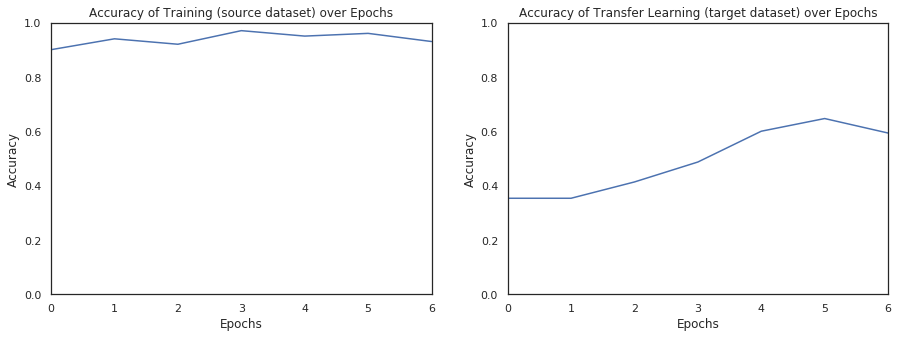

In [0]:
#@title Graphs of accuracy over epochs

sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("white")
# sns.set(ylim=(0, 100))
# sns.set(xlim=(0, 1))

#graph one
df_plot_one = pd.DataFrame()
df_plot_one['Accuracy'] = accuracy_over_epochs_source
df_plot_one['Epochs'] = range(number_of_epochs)

plot_one = plt.subplot(121)
sns.lineplot(x='Epochs', y='Accuracy', data=df_plot_one).set_title('Accuracy of Training (source dataset) over Epochs')
plot_one.set(ylim=(0, 1))
plot_one.set(xlim=(0, number_of_epochs-1))

#graph two
df_plot_two = pd.DataFrame()
df_plot_two['Accuracy'] = accuracy_over_epochs_target
df_plot_two['Epochs'] = range(number_of_epochs)

plot_two = plt.subplot(122)
sns.lineplot(x='Epochs', y='Accuracy', data=df_plot_two).set_title('Accuracy of Transfer Learning (target dataset) over Epochs')
plot_two.set(ylim=(0, 1))
plot_two.set(xlim=(0, number_of_epochs-1))

plt.show()

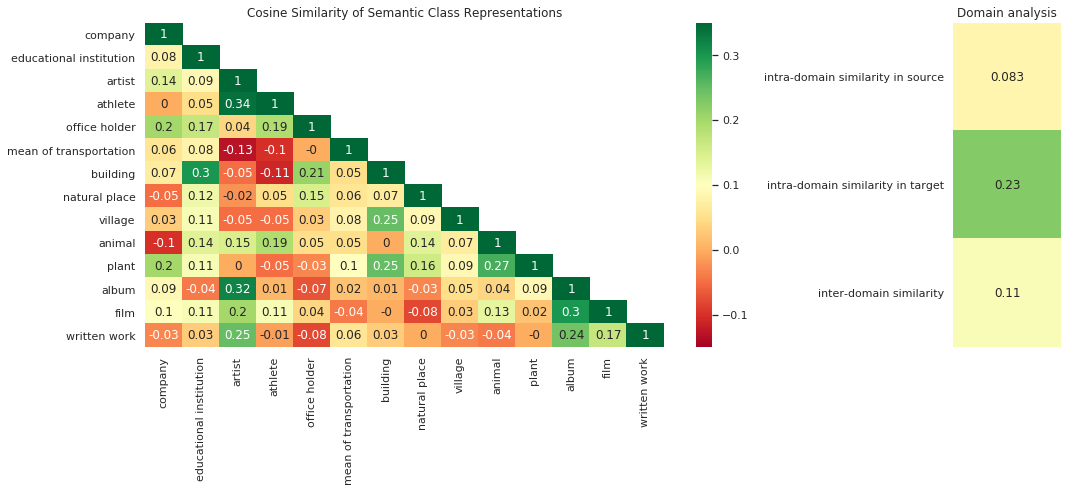

In [0]:
#@title Graph of cosine similarity of semantics
cosine_dict = {'company': {'company': 1.0, 'educational institution': 0.08263344, 'artist': 0.14111201, 'athlete': 0.0033369786, 'office holder': 0.20412439, 'mean of transportation': 0.064943865, 'building': 0.06924404, 'natural place': -0.054548133, 'village': 0.026765125, 'animal': -0.10398324, 'plant': 0.20429958, 'album': 0.08837815, 'film': 0.09861728, 'written work': -0.031029703}, 'educational institution': {'company': 0.08263344, 'educational institution': 1.0, 'artist': 0.08806808, 'athlete': 0.05205103, 'office holder': 0.16751571, 'mean of transportation': 0.08016642, 'building': 0.30250677, 'natural place': 0.1160425, 'village': 0.112509795, 'animal': 0.13556263, 'plant': 0.11072394, 'album': -0.042958908, 'film': 0.109838784, 'written work': 0.03267837}, 'artist': {'company': 0.14111201, 'educational institution': 0.08806808, 'artist': 1.0, 'athlete': 0.33690554, 'office holder': 0.04316269, 'mean of transportation': -0.13361783, 'building': -0.04595822, 'natural place': -0.024134284, 'village': -0.04783458, 'animal': 0.14936452, 'plant': 0.003789491, 'album': 0.31538036, 'film': 0.20432745, 'written work': 0.24760288}, 'athlete': {'company': 0.0033369786, 'educational institution': 0.05205103, 'artist': 0.33690554, 'athlete': 1.0000001, 'office holder': 0.19143705, 'mean of transportation': -0.09887549, 'building': -0.11041512, 'natural place': 0.046233423, 'village': -0.0524722, 'animal': 0.18852538, 'plant': -0.049992945, 'album': 0.013265924, 'film': 0.112318285, 'written work': -0.0068381643}, 'office holder': {'company': 0.20412439, 'educational institution': 0.16751571, 'artist': 0.04316269, 'athlete': 0.19143705, 'office holder': 0.99999994, 'mean of transportation': -0.004174981, 'building': 0.20623715, 'natural place': 0.15120585, 'village': 0.030082209, 'animal': 0.052497216, 'plant': -0.028751845, 'album': -0.07379075, 'film': 0.041413352, 'written work': -0.07976488}, 'mean of transportation': {'company': 0.064943865, 'educational institution': 0.08016642, 'artist': -0.13361783, 'athlete': -0.09887549, 'office holder': -0.004174981, 'mean of transportation': 1.0, 'building': 0.05487365, 'natural place': 0.061781786, 'village': 0.083420455, 'animal': 0.049818087, 'plant': 0.097866945, 'album': 0.017213743, 'film': -0.04366608, 'written work': 0.060961474}, 'building': {'company': 0.06924404, 'educational institution': 0.30250677, 'artist': -0.04595822, 'athlete': -0.11041512, 'office holder': 0.20623715, 'mean of transportation': 0.05487365, 'building': 0.99999994, 'natural place': 0.071529925, 'village': 0.25317585, 'animal': 0.0032489332, 'plant': 0.24990301, 'album': 0.009656263, 'film': -0.00042323692, 'written work': 0.034905963}, 'natural place': {'company': -0.054548133, 'educational institution': 0.1160425, 'artist': -0.024134284, 'athlete': 0.046233423, 'office holder': 0.15120585, 'mean of transportation': 0.061781786, 'building': 0.071529925, 'natural place': 0.99999994, 'village': 0.093101956, 'animal': 0.14415589, 'plant': 0.1580701, 'album': -0.030855065, 'film': -0.08251612, 'written work': 0.004913299}, 'village': {'company': 0.026765125, 'educational institution': 0.112509795, 'artist': -0.04783458, 'athlete': -0.0524722, 'office holder': 0.030082209, 'mean of transportation': 0.083420455, 'building': 0.25317585, 'natural place': 0.093101956, 'village': 1.0, 'animal': 0.06979489, 'plant': 0.0853521, 'album': 0.04799434, 'film': 0.032153614, 'written work': -0.027798329}, 'animal': {'company': -0.10398324, 'educational institution': 0.13556263, 'artist': 0.14936452, 'athlete': 0.18852538, 'office holder': 0.052497216, 'mean of transportation': 0.049818087, 'building': 0.0032489332, 'natural place': 0.14415589, 'village': 0.06979489, 'animal': 1.0, 'plant': 0.26802897, 'album': 0.040853336, 'film': 0.13204014, 'written work': -0.037124444}, 'plant': {'company': 0.20429958, 'educational institution': 0.11072394, 'artist': 0.003789491, 'athlete': -0.049992945, 'office holder': -0.028751845, 'mean of transportation': 0.097866945, 'building': 0.24990301, 'natural place': 0.1580701, 'village': 0.0853521, 'animal': 0.26802897, 'plant': 1.0, 'album': 0.094578125, 'film': 0.0170119, 'written work': -0.0008432053}, 'album': {'company': 0.08837815, 'educational institution': -0.042958908, 'artist': 0.31538036, 'athlete': 0.013265924, 'office holder': -0.07379075, 'mean of transportation': 0.017213743, 'building': 0.009656263, 'natural place': -0.030855065, 'village': 0.04799434, 'animal': 0.040853336, 'plant': 0.094578125, 'album': 1.0, 'film': 0.30355102, 'written work': 0.23874569}, 'film': {'company': 0.09861728, 'educational institution': 0.109838784, 'artist': 0.20432745, 'athlete': 0.112318285, 'office holder': 0.041413352, 'mean of transportation': -0.04366608, 'building': -0.00042323692, 'natural place': -0.08251612, 'village': 0.032153614, 'animal': 0.13204014, 'plant': 0.0170119, 'album': 0.30355102, 'film': 1.0, 'written work': 0.17075649}, 'written work': {'company': -0.031029703, 'educational institution': 0.03267837, 'artist': 0.24760288, 'athlete': -0.0068381643, 'office holder': -0.07976488, 'mean of transportation': 0.060961474, 'building': 0.034905963, 'natural place': 0.004913299, 'village': -0.027798329, 'animal': -0.037124444, 'plant': -0.0008432053, 'album': 0.23874569, 'film': 0.17075649, 'written work': 1.0}}
cosine_table = np.zeros((len(cosine_dict), len(cosine_dict)))

labels = []
for i, (key, val) in enumerate(cosine_dict.items()):  
    labels.append(key)
    for j, cos in enumerate(val.values()):  cosine_table[i][j] = cos
      
cosine_table = np.around(cosine_table, decimals=2)

mask = np.zeros_like(cosine_table)
mask[np.triu_indices_from(mask)] = True
for i in range(len(mask)): mask[i][i] = 0

similarity_labels = ['intra-domain similarity in source', 'intra-domain similarity in target', 'inter-domain similarity']
similarity_table= [[dataset.source_class_similarity, dataset.target_class_similarity, dataset.source_target_similarity]]
similarity_table = np.around(similarity_table, decimals=3).T

#### plot
fig = plt.figure(figsize=(15, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[12, 2]) 
ax0 = plt.subplot(gs[0])

sns.heatmap(cosine_table, mask=mask, annot=True, cmap='RdYlGn', xticklabels=labels, yticklabels=labels, vmin=-0.15, vmax=0.35)

plt.title('Cosine Similarity of Semantic Class Representations')

ax1 = plt.subplot(gs[1])
sns.heatmap(similarity_table, annot=True, cmap='RdYlGn',  yticklabels=similarity_labels, vmin=-0.15, vmax=0.35, cbar=False)
ax1.get_xaxis().set_visible(False)
plt.title('Domain analysis')

plt.tight_layout()

## Default graphs produced by us for comparison reasons

### Effects of fraction of training data for transfer learning model (target dataset) for each model
<img src="https://raw.githubusercontent.com/danikgan/nlp-data/master/figures/experiment_1_all.png" width="1500"/>

### The effects of freezing layers and vocabulary size analysis
<img src="https://raw.githubusercontent.com/danikgan/nlp-data/master/figures/experiment_3.png" width="1500"/>
<!-- ### The effects of freezing layers on Attention-based Bi-LSTM Model
<img src="https://raw.githubusercontent.com/danikgan/nlp-data/master/figures/exp3_bi_lstm_frozen.png" width="500"/> -->